In [36]:
using LinearAlgebra

In [17]:
# using Pkg
# Pkg.test("Apophis")
using CairoMakie, AlgebraOfGraphics
CairoMakie.activate!(type="svg")
using Flux

In [79]:
using Apophis
init(:GRI3, 1000.0, 1013250.0, CH4=0.05, N2=0.75, O2=0.2)
loss(x, y) = Flux.Losses.mse(predict(x), y);

In [103]:
rnd = rand(1:10, 1, 53)
T_train = only(gas.initial.temperature) # 1000.0#rand(750.0:1500.0)
Y_train = gas.initial.mass_fractions' # rnd / sum(rnd)
step!(gas, Y_train[:], T_train)
ω_train = gas.intermediate.production_rate
predict = Dense(1 => 1)
parameters = Flux.params(predict)
loss(Y_train, ω_train')

0.008882659480957946

In [104]:
using Flux: train!
opt = Descent()
data = [(Y_train, ω_train')]

1-element Vector{Tuple{LinearAlgebra.Adjoint{Float64, Vector{Float64}}, LinearAlgebra.Adjoint{Float64, Vector{Float64}}}}:
 ([0.0 0.0 … 0.0 0.0], [0.0 3.7072899145012654e-14 … 0.0 0.0])

In [105]:
for epoch in 1:1e4
    train!(loss, parameters, data, opt)
end

In [106]:
loss(Y_train, ω_train')

1.0861260807723895e-21

In [107]:
predict(Y_train)'

53×1 adjoint(::Matrix{Float64}) with eltype Float64:
 -3.388863625483629e-12
 -3.388863625483629e-12
 -3.388863625483629e-12
  3.2059877539195036e-11
 -3.388863625483629e-12
 -3.388863625483629e-12
 -3.388863625483629e-12
 -3.388863625483629e-12
 -3.388863625483629e-12
 -3.388863625483629e-12
  ⋮
 -3.388863625483629e-12
 -3.388863625483629e-12
 -3.388863625483629e-12
  1.2954391574206137e-10
 -3.388863625483629e-12
 -3.388863625483629e-12
 -3.388863625483629e-12
 -3.388863625483629e-12
 -3.388863625483629e-12

In [3]:
timesInterpolate = Float64[]
timesDirect = Float64[]
mechanisms = [:H2, :SynGas, :GRI12, :GRI2, :GRI3, :ITV]
for i in mechanisms
    init(i, 1000.0, 1013250.0, H2=0.05, N2=0.75, O2=0.2)
    tstart = time()
    bsol = Apophis.backwardInterpolate(gas)
    tend = time()
    push!(timesInterpolate, tend - tstart)
    tstart = time()
    Apophis.backwardDirect(gas)
    tend = time()
    push!(timesDirect, tend - tstart)
end

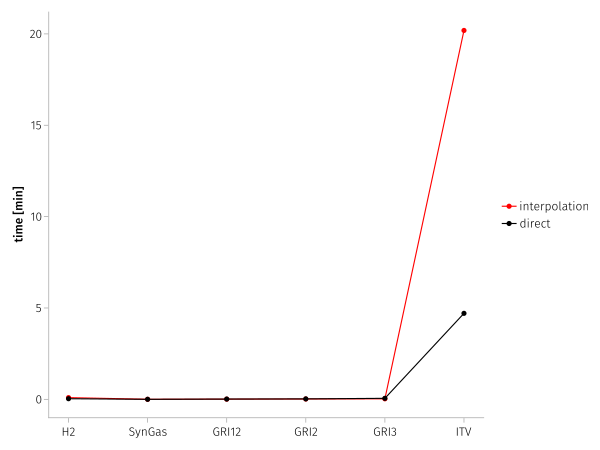

In [7]:
set_aog_theme!()
f = Figure()
numbers = 1:6
Axis(f[1, 1], ylabel="time [min]", xticks=(numbers, String.(mechanisms[numbers])))

tI = scatterlines!(numbers, timesInterpolate[numbers] / 60, markercolor=:red, color=:red)
tD = scatterlines!(numbers, timesDirect[numbers]/60, markercolor=:black, color=:black)
Legend(f[1, 2], [tI, tD], ["interpolation", "direct"])
#sl_x = Slider(f[2, 1], range = 1:6, startvalue = 3)
display(f)

In [109]:
fig = Figure()
menu = Menu(fig, options = ["viridis", "heat", "blues"])

Menu()

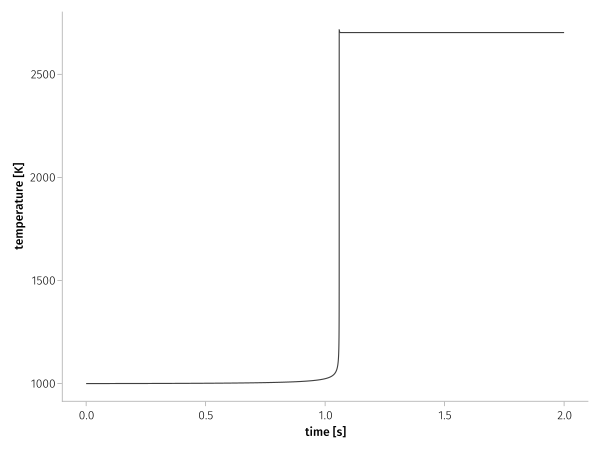

In [4]:
forward_profile(sol, 54)

In [ ]:
ccall #flamemaster
PyCall #cantera

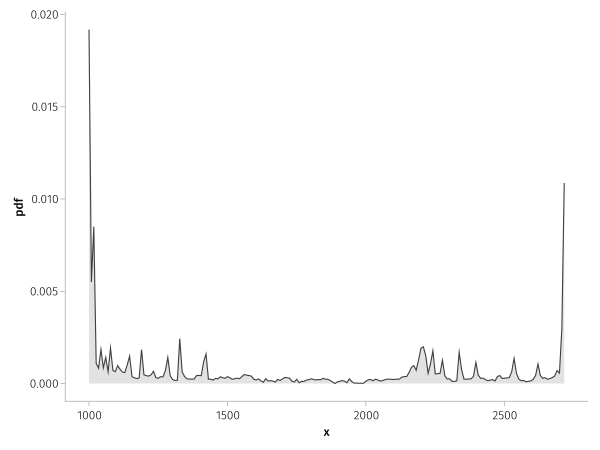

In [20]:
using AlgebraOfGraphics: density

df = (x=sol[end, :], c=rand(["a", "b"], length(sol.t)))
plt = data(df) * mapping(:x) * density(bandwidth=0.75)
fg = draw(plt)

In [21]:
c=rand(["a", "b"], 1000)

1000-element Vector{String}:
 "a"
 "b"
 "a"
 "b"
 "a"
 "b"
 "a"
 "b"
 "b"
 "a"
 ⋮
 "b"
 "b"
 "b"
 "b"
 "a"
 "b"
 "b"
 "b"
 "a"

In [26]:
sol

retcode: Success
Interpolation: 3rd order Hermite
t: 2035-element Vector{Float64}:
 0.0
 4.592505432841547e-8
 0.0001387426580922087
 0.000437943718733841
 0.0007371447793754732
 0.0010363458400171055
 0.0015426181785473904
 0.002048890517077675
 0.0031185335803646866
 0.004188176643651698
 ⋮
 1.096612331398812
 1.104846940947004
 1.113081550495196
 1.126759616960873
 1.1404376834265497
 1.1714820159848243
 1.323225480508066
 1.8072710493541682
 2.0
u: 2035-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 1000.0]
 [9.571581660310476e-20, 4.914010933229725e-18, 4.939929892740754e-19, 0.19999999999961957, 1.899376330885745e-18, 1.2580826484005362e-19, 3.9243497931268456e-13, 1.1173390619207651e-18, 2.3278207878960489e-35, 1.224280541613251e-31  …  0.0, 0.0, 5.148778834245664e-46, 0.75, 0.0, 3.9223882314881946e-43, 8.056979165537298e-39, 4.51485499661986e-42, 1.8568232361216077e-46, 999.9999999972486]
 [6

In [28]:
TerminateSteadyState()

UndefVarError: UndefVarError: TerminateSteadyState not defined

In [11]:
using DiffEqCallbacks
TerminateSteadyState()

SciMLBase.DiscreteCallback{DiffEqCallbacks.var"#55#57"{Nothing, Float64, Float64, typeof(DiffEqCallbacks.allDerivPass)}, DiffEqCallbacks.var"#56#58", typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}(DiffEqCallbacks.var"#55#57"{Nothing, Float64, Float64, typeof(DiffEqCallbacks.allDerivPass)}(nothing, 1.0e-8, 1.0e-6, DiffEqCallbacks.allDerivPass), DiffEqCallbacks.var"#56#58"(), SciMLBase.INITIALIZE_DEFAULT, SciMLBase.FINALIZE_DEFAULT, Bool[1, 0])

In [33]:
sol = solve(prob,alg;callback=TerminateSteadyState)

UndefVarError: UndefVarError: TerminateSteadyState not defined

In [37]:
using DiffEqCallbacks
TerminateSteadyState

TerminateSteadyState (generic function with 4 methods)

In [33]:
x = rand(0.0:0.01:1.0, 3)
A = rand(-2:2, 2, 3)
y = sig.(A * x)

2-element Vector{Float64}:
 0.31002551887238755
 0.8115326747861805

In [32]:
W = rand(-2:2, 2, 3)
b = rand(-2:2, 2)
z = W * x + b
sig.(z)

2-element Vector{Float64}:
 0.9088770389851438
 0.06913842034334682

In [41]:
cost(a, y) = (a-y)^2

cost (generic function with 1 method)

In [42]:
cost.(sig.(z), y)

2-element Vector{Float64}:
 0.35862314314135885
 0.5511492290297308